In [1]:
import pandas
import seaborn

In [2]:
df = pandas.read_pickle("5-value-iterations.pkl.gz")
df

,problem,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,protocol,dag_size_limit,size,...,vi_time,vi_max_value,ss_reachable,ss_nonzero,ss_time,pe_iter,ptrev,rpp,time,vi_steady_value
0,ref-aft20,aft20barzur,True,True,True,True,True,bitcoin,6,37,...,0.183302,9.625739,13,13,0.055014,2,0.024750,0.050000,0.239126,4.939711
1,ref-fc16,fc16sapirshtein,True,True,True,True,True,bitcoin,6,47,...,0.193454,9.653684,15,15,0.047375,2,0.049500,0.050000,0.242305,4.940165
2,v1+fc,generic-v1,True,False,True,True,True,bitcoin,6,549,...,2.922894,9.452998,5,5,0.001068,2,0.024750,0.050000,2.932980,4.940214
3,v1+fc,generic-v1,True,False,True,True,True,ethereum_3,6,1179,...,6.148843,9.683072,170,170,0.004253,2,0.024233,0.052591,6.172071,5.210661
4,v1+fc,generic-v1,True,False,True,True,True,byzantium_3,6,1109,...,5.232705,9.847424,5,5,0.001035,2,0.024750,0.050000,5.252043,4.940214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,v1+n,generic-v1,False,True,True,True,True,ethereum_3,6,10293,...,152.900283,87.836049,186,186,0.004036,2,0.194125,0.861063,153.069348,84.820546
476,v1+n,generic-v1,False,True,True,True,True,ghostdag_3,6,12644,...,107.068477,56.874280,128,128,0.002502,2,0.190198,0.560976,107.292039,54.565483
477,v0,generic-v0,False,False,True,True,True,bitcoin,6,42041,...,1169.216771,67.247173,127,127,0.002609,2,0.182107,0.657496,1171.149323,65.400032
478,v0,generic-v0,False,False,True,True,True,bitcoin,6,42041,...,1032.341103,68.968838,145,145,0.002393,2,0.181175,0.679094,1034.699929,67.415818


In [3]:
df.columns

Index(['problem', 'model', 'force_consider_own', 'merge_isomorphic',
       'truncate_common_chain', 'collect_garbage', 'reward_common_chain',
       'protocol', 'dag_size_limit', 'size', 'time_spent', 'rss', 'mdp',
       'horizon', 'alpha', 'gamma', 'vi_discount', 'vi_delta', 'vi_stop_delta',
       'vi_progress', 'vi_iter', 'vi_max_iter', 'vi_time', 'vi_max_value',
       'ss_reachable', 'ss_nonzero', 'ss_time', 'pe_iter', 'ptrev', 'rpp',
       'time', 'vi_steady_value'],
      dtype='object')

In [4]:
dsl = df.dag_size_limit.drop_duplicates()
assert len(dsl) == 1
dag_size_limit = dsl.iloc[0]
dag_size_limit

6

# Reward per progress, source-model, steady state

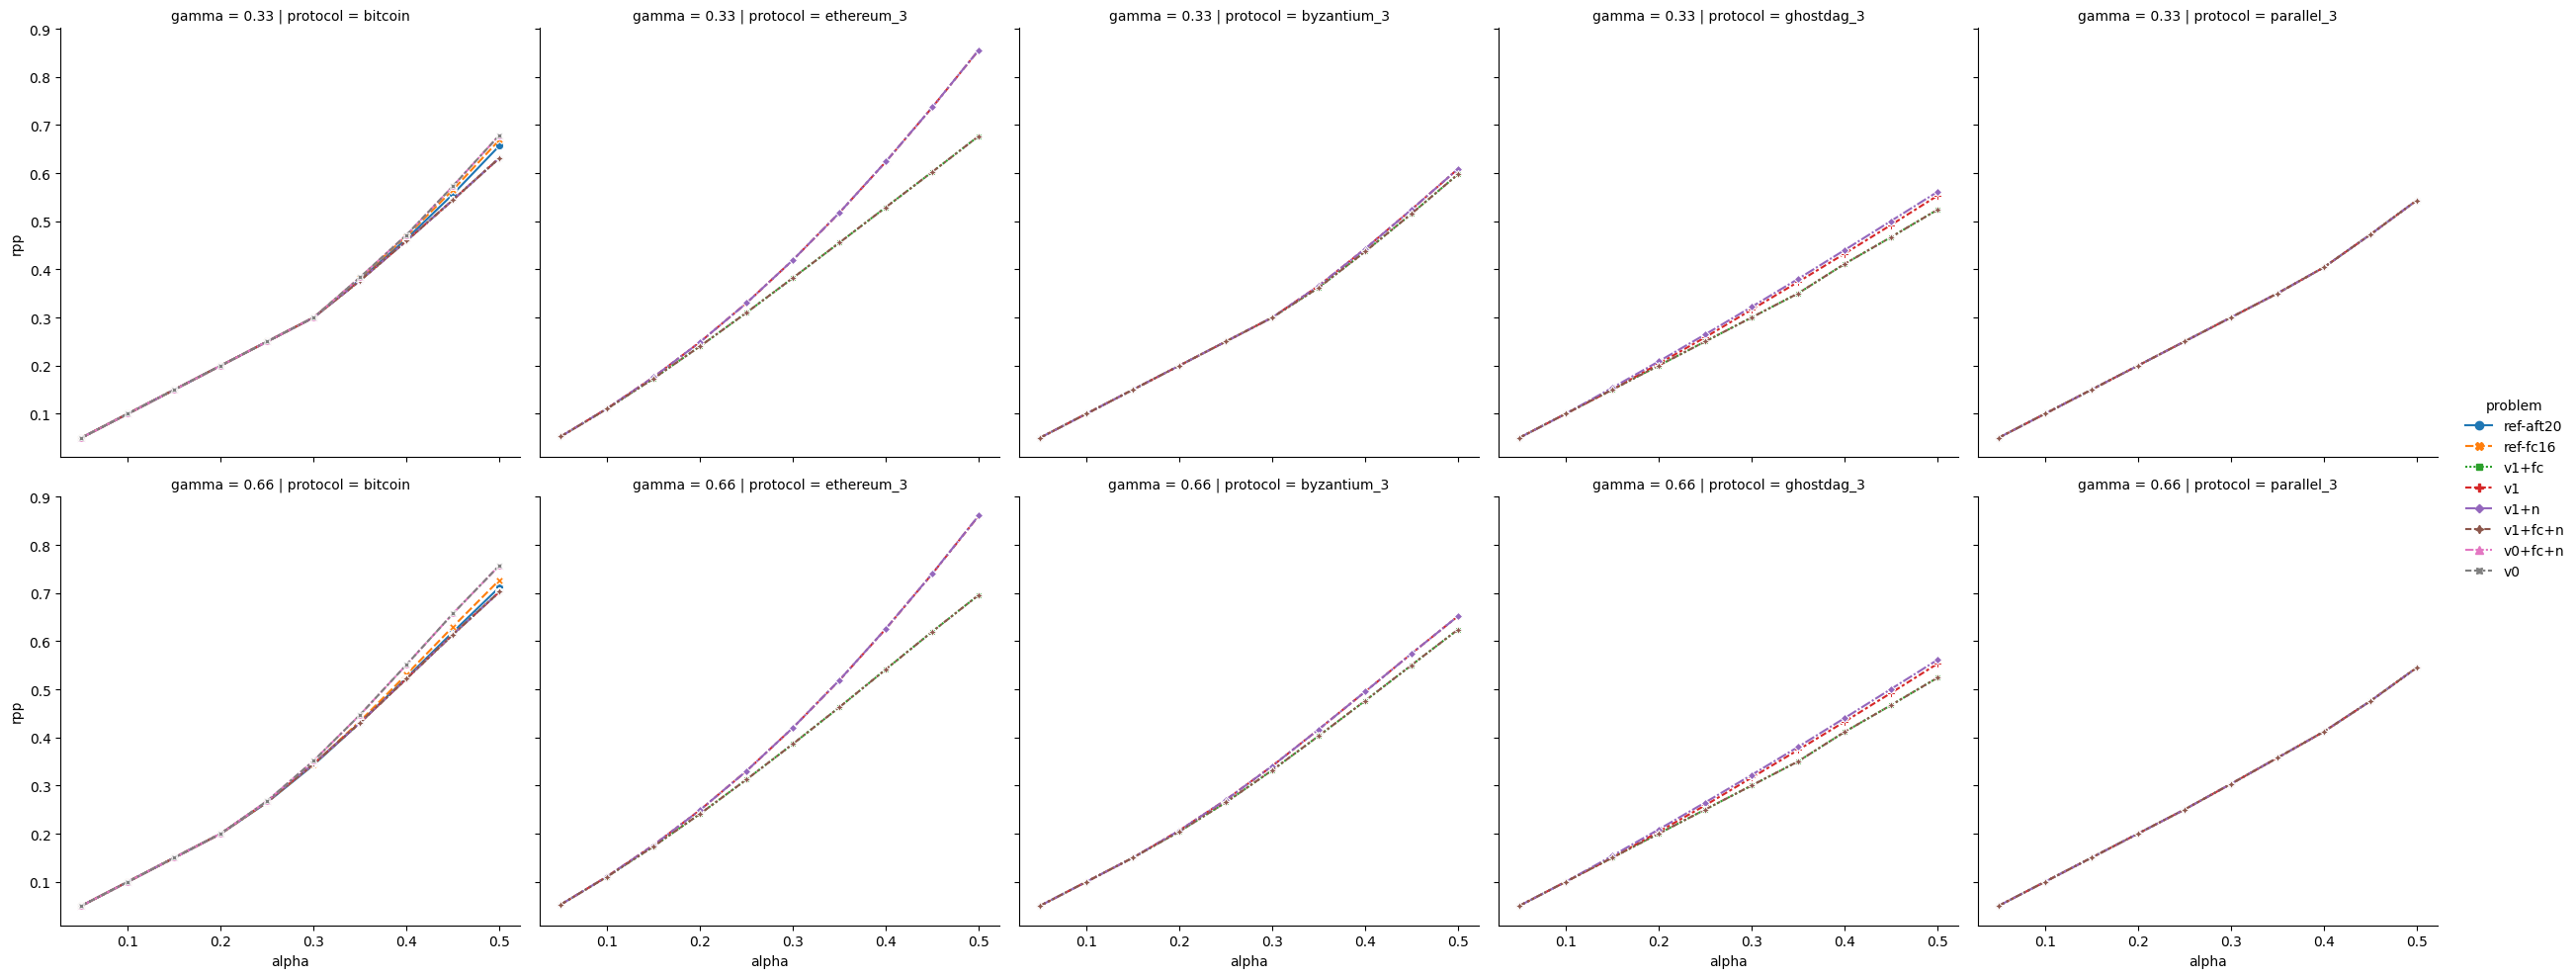

In [5]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="rpp",
    hue="problem",
    style="problem",
    markers=True,
    col="protocol",
    row="gamma",
)

## Validation v0

The following was lining up perfectly for the first preprint version at maximum fork length = 13

In [6]:
dag_size_limit

6

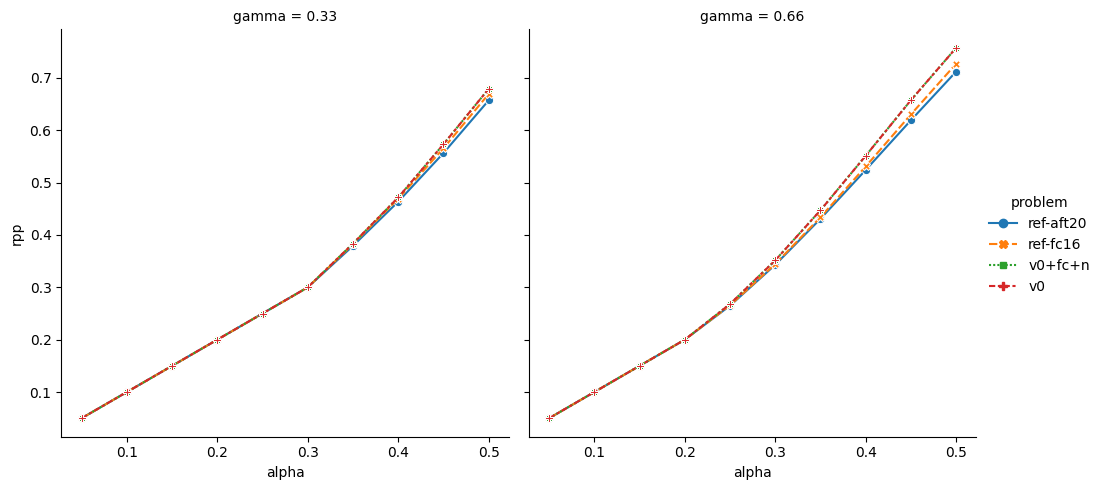

In [7]:
seaborn.relplot(
    data=df.query(
        'protocol == "bitcoin" and (problem.str.startswith("ref") or problem == "v0+fc+n" or problem == "v0")'
    ),
    kind="line",
    x="alpha",
    y="rpp",
    hue="problem",
    style="problem",
    markers=True,
    col="gamma",
)

## Validation v1

The following should line up; I want to claim it in the paper

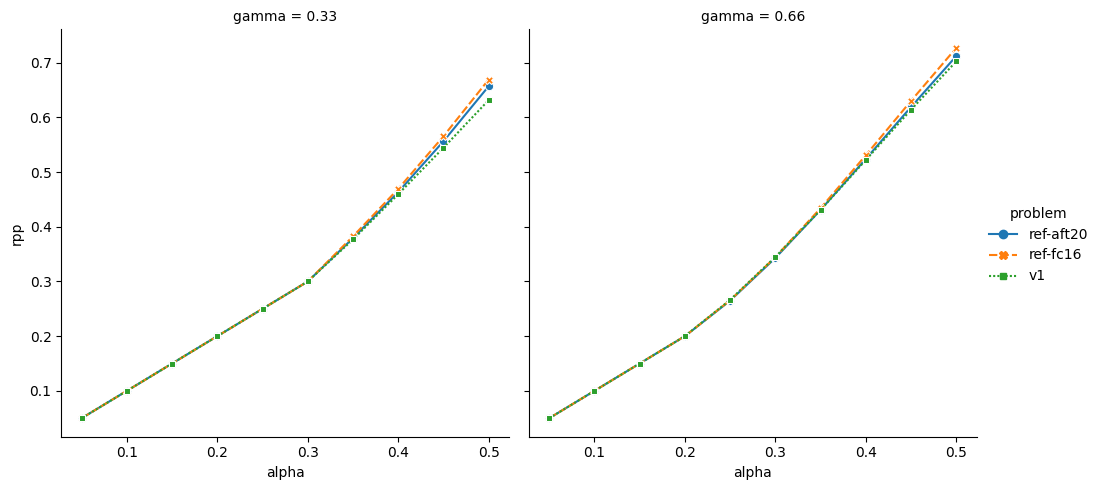

In [8]:
seaborn.relplot(
    data=df.query(
        'protocol == "bitcoin" and (problem.str.startswith("ref") or problem == "v1")'
    ),
    kind="line",
    x="alpha",
    y="rpp",
    hue="problem",
    style="problem",
    markers=True,
    col="gamma",
)

## H: v1 optimizations are neutral for all protocols

No. Exceptions:
- In Ethereum and Byzantium force-consider restricts the attacker. The optimal policy ignores some own blocks.
- In Parallel, canonization seems to enable attacks. I have no glue how this can be.
- In Ghostdag, canonization seems to mitigate attacks. I have no glue how this can be.
- In Ghostdag, canonization causes a split such that force-consider mitigates attacks. I have no glue how this can be.

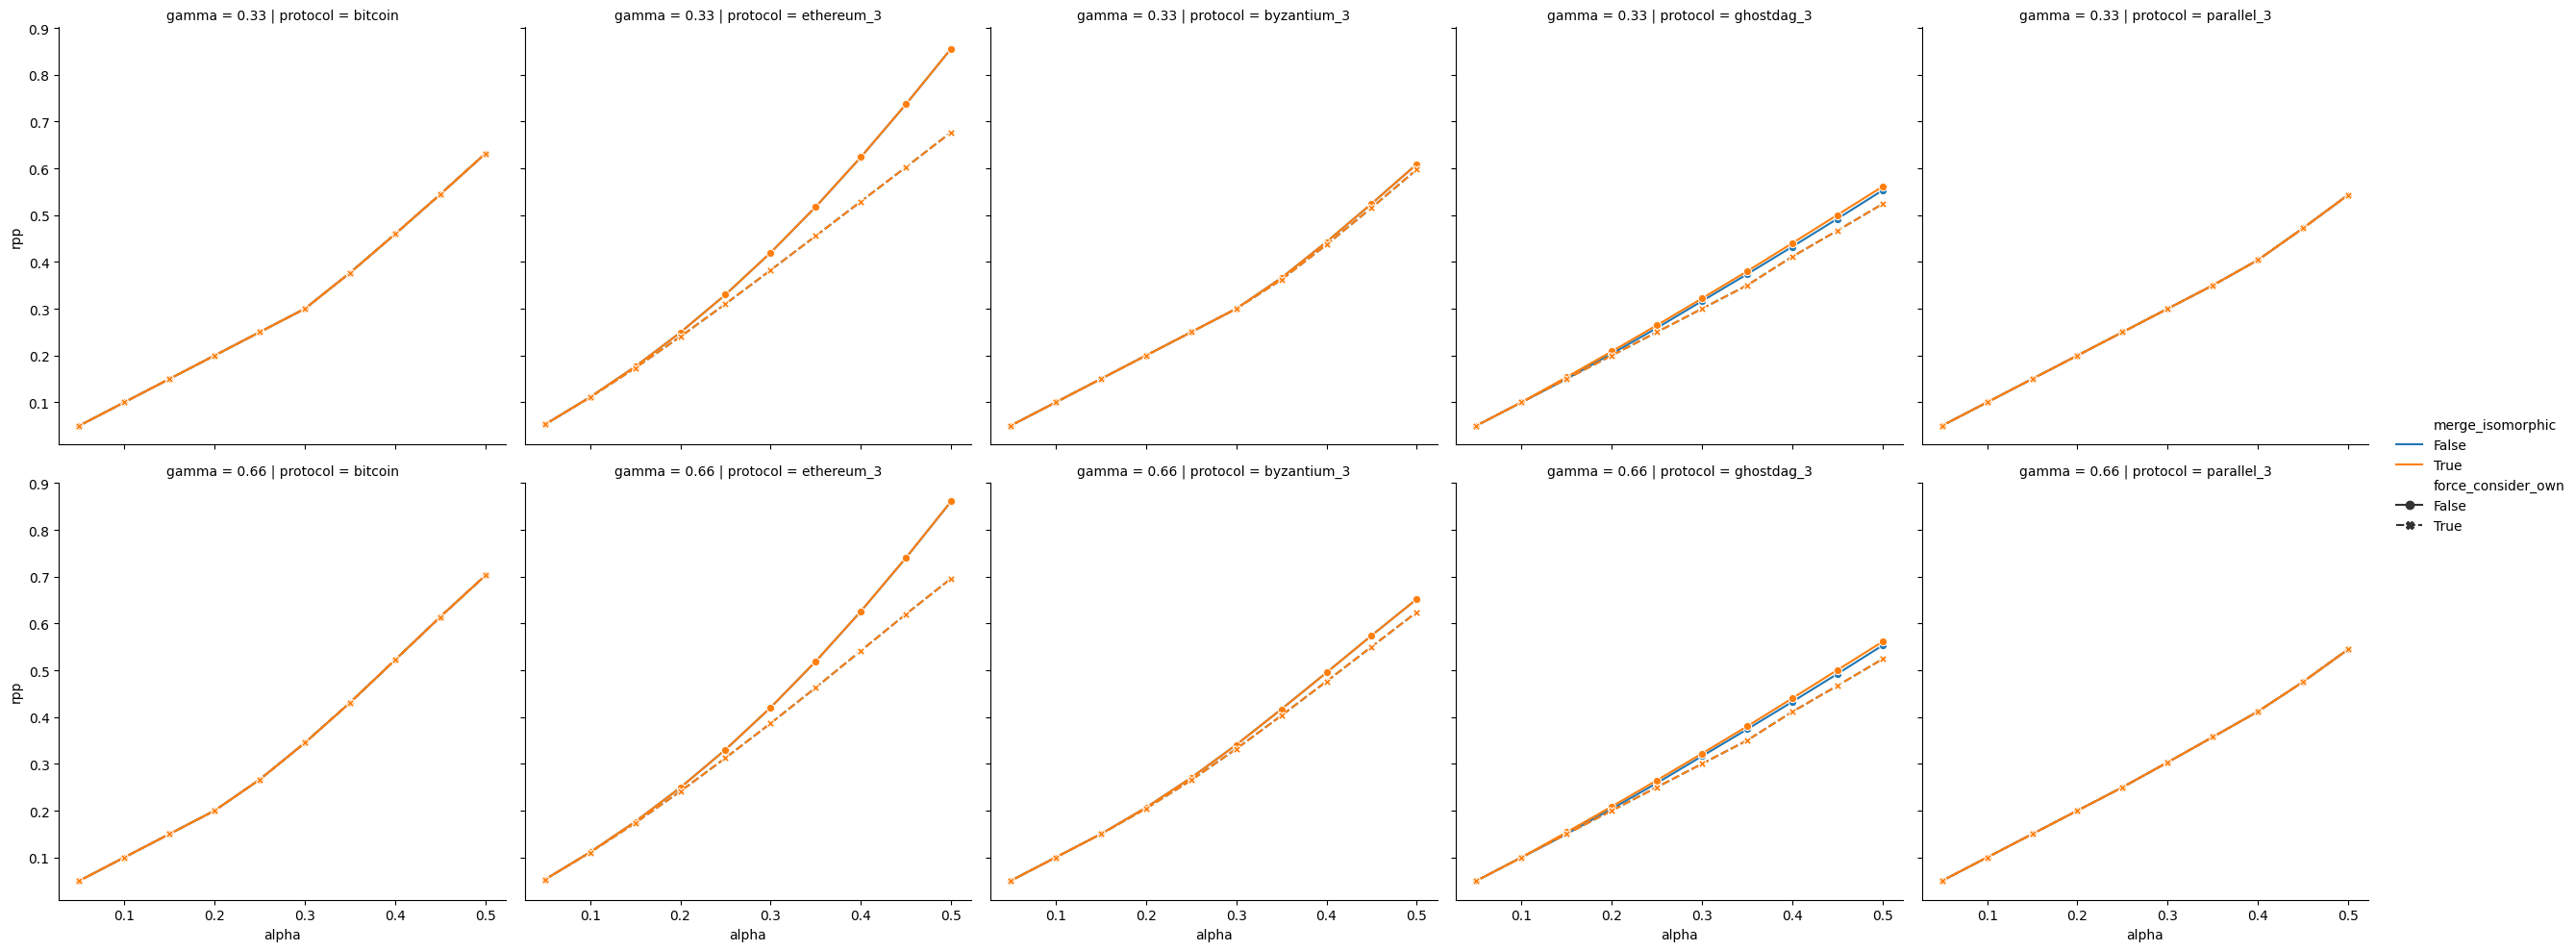

In [9]:
seaborn.relplot(
    data=df.query('problem.str.startswith("v1")'),
    kind="line",
    x="alpha",
    y="rpp",
    style="force_consider_own",
    hue="merge_isomorphic",
    markers=True,
    col="protocol",
    row="gamma",
)

# Prepare CSV for paper

In [10]:
rpp_of_alpha = df.assign(
    column=lambda d: [
        f"{r.problem}:{r.protocol}:gamma{str(r.gamma)[2:]}:dsl{r.dag_size_limit}"
        for _, r in d.iterrows()
    ]
).pivot(index="alpha", columns="column", values="rpp")
rpp_of_alpha.to_csv("5-rpp-of-alpha.csv")
rpp_of_alpha

column,ref-aft20:bitcoin:gamma33:dsl6,ref-aft20:bitcoin:gamma66:dsl6,ref-fc16:bitcoin:gamma33:dsl6,ref-fc16:bitcoin:gamma66:dsl6,v0+fc+n:bitcoin:gamma33:dsl6,v0+fc+n:bitcoin:gamma66:dsl6,v0:bitcoin:gamma33:dsl6,v0:bitcoin:gamma66:dsl6,v1+fc+n:bitcoin:gamma33:dsl6,v1+fc+n:bitcoin:gamma66:dsl6,...,v1:bitcoin:gamma33:dsl6,v1:bitcoin:gamma66:dsl6,v1:byzantium_3:gamma33:dsl6,v1:byzantium_3:gamma66:dsl6,v1:ethereum_3:gamma33:dsl6,v1:ethereum_3:gamma66:dsl6,v1:ghostdag_3:gamma33:dsl6,v1:ghostdag_3:gamma66:dsl6,v1:parallel_3:gamma33:dsl6,v1:parallel_3:gamma66:dsl6
alpha,,,,,,,,,,,,,,,,,,,,,
0.05,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,...,0.050000,0.050000,0.050000,0.050000,0.052625,0.052631,0.050000,0.050000,0.050000,0.050000
0.10,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,...,0.100000,0.100000,0.100000,0.100000,0.111090,0.111091,0.100000,0.100000,0.100000,0.100000
0.15,0.150000,0.150000,0.150000,0.150000,0.150000,0.150000,0.150000,0.150000,0.150000,0.150000,...,0.150000,0.150000,0.150000,0.150000,0.176275,0.176288,0.150000,0.150000,0.150000,0.150000
0.20,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,...,0.200000,0.200000,0.200000,0.206580,0.249042,0.249103,0.203976,0.203976,0.200000,0.200000
0.25,0.250000,0.264940,0.250000,0.265624,0.250000,0.268139,0.250000,0.268139,0.250000,0.266454,...,0.250000,0.266454,0.250000,0.270165,0.330051,0.330253,0.258762,0.258762,0.250000,0.250000
0.30,0.300000,0.343030,0.300000,0.344572,0.300000,0.351576,0.300000,0.351576,0.300000,0.344926,...,0.300000,0.344926,0.300000,0.340623,0.419636,0.420148,0.316323,0.316323,0.300000,0.303255
0.35,0.379228,0.430903,0.382590,0.433947,0.383640,0.447182,0.383640,0.447182,0.376756,0.430699,...,0.376756,0.430699,0.365913,0.416741,0.517720,0.518797,0.373805,0.373805,0.350000,0.357337
0.40,0.463624,0.524166,0.469260,0.530847,0.471679,0.551257,0.471679,0.551257,0.459507,0.522086,...,0.459507,0.522086,0.442837,0.494995,0.623781,0.625756,0.432492,0.432492,0.404098,0.411835
0.45,0.556353,0.619149,0.565515,0.630253,0.573249,0.657496,0.573249,0.657496,0.544463,0.614088,...,0.544463,0.614088,0.524532,0.574348,0.736878,0.740134,0.492208,0.492208,0.472166,0.475219
